In [1]:
################## Explore IBCAO Bathymetry Data #################
# The purpose of this script is to explore the IBCAO 
# Bathymetry data in the region we are basing the idealized model 
# on to see how it looks and if we should alter our idealized
# bathymetry to be based on that.
#
# Notes:
# - This will be edited to also explore GEBCO since that has 
#   data in lat/lon and is therefore easier to use
#
###################################################################

In [2]:
# Load in the packages
#matplotlib widget 
import numpy as np
import datetime
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from matplotlib.path import Path
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import cmocean
import cartopy.crs as ccrs
import pandas as pd
import math
from scipy import interpolate
from scipy.optimize import curve_fit
import sys
#import gridmap

In [3]:
# Load in the IBCAO data
ibcao_data = xr.open_dataset('/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/IBCAO_v4_1_200m.nc')

In [4]:
# Make a function to convert to lat/lon
# Make a function to do the conversion
def polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere):
    """Convert from Polar Stereographic (x, y) coordinates to
    geodetic longitude and latitude.

    Args:
        x (float): X coordinate(s) in km
        y (float): Y coordinate(s) in km
        true_scale_lat (float): true-scale latitude in degrees
        hemisphere (1 or -1): 1 for Northern hemisphere, -1 for Southern
        re (float): Earth radius in km
        e (float): Earth eccentricity

    Returns:
        If x and y are scalars then the result is a
        two-element list containing [longitude, latitude].
        If x and y are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.
    """

    e2 = e * e
    slat = true_scale_lat * np.pi / 180
    rho = np.sqrt(x ** 2 + y ** 2)

    if abs(true_scale_lat - 90.) < 1e-5:
        t = rho * np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e)) / (2 * re)
    else:
        cm = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        t = np.tan((np.pi / 4) - (slat / 2)) / \
            ((1 - e * np.sin(slat)) / (1 + e * np.sin(slat))) ** (e / 2)
        t = rho * t / (re * cm)

    chi = (np.pi / 2) - 2 * np.arctan(t)
    lat = chi + \
        ((e2 / 2) + (5 * e2 ** 2 / 24) + (e2 ** 3 / 12)) * np.sin(2 * chi) + \
        ((7 * e2 ** 2 / 48) + (29 * e2 ** 3 / 240)) * np.sin(4 * chi) + \
        (7 * e2 ** 3 / 120) * np.sin(6 * chi)
    lat = hemisphere * lat * 180 / np.pi
    lon = np.arctan2(hemisphere * x, -hemisphere * y)
    lon = hemisphere * lon * 180 / np.pi
    lon = lon + np.less(lon, 0) * 360
    return [lon, lat]

In [5]:
# Coordinates of rectangle in form of x min, x max, y min, and y max
# Each color corresponds to a different rectangle, comment out rectangles as needed 

# Red rectangle
x1, x2 = (-1.4e6), (-1.25e6) # x min, x max
y1, y2 = (1.73e6), (1.82e6) # y min, y max

# Green rectangle
x12, x22 = (-1.34e6), (-1.24e6) # x min, x max
y12, y22 = (1.7e6), (1.78e6) # y min, y max

# Purple rectangle, the OG grid
x13, x23 = (-1335773.817), (-1235773.817) # x min, x max
y13, y23 = (1690936.922), (1780936.922) #y min, y max

# Orange rectangle, the new grid
x14, x24 = (-1.340500e6), (-8.86e5) # x min, x max 
y14, y24 = (1.664e6), (1.7864e6) # y min, y max 

# Yellow rectangle
x15, x25 = (-1.35e6), (-1.24e6) # x min, x max
y15, y25 = (1.72e6), (1.78e6) # y min, y max

In [6]:
# # Plot this?
# # Create the map of the Arctic bathymetry and plot the rectangles on it
# # Create the figure
# fig1, ax1 = plt.subplots() #figsize = (15,10)

# # Set angle of grid rotation, rotating from the east
# angle_og = 25 # degrees
# angle2 = 22 # degrees

# # Create the rectangles, input in form (coordinates of bottom left corner, width, height)
# # Red
# #rect = patches.Rectangle((x1, y1), (x2-x1),(y2-y1), linewidth=3, edgecolor='r', 
#                          #facecolor='none')

# # Green
# #rect2 = patches.Rectangle((x12, y12), (x22-x12),(y22-y12), linewidth=3, edgecolor='g',
#                           #facecolor='none', angle=angle1)

# # Purple (OG grid)
# rect3 = patches.Rectangle((x13, y13), (x23-x13), (y23-y13), linewidth=3, edgecolor='purple', 
#                           facecolor='none', angle=angle_og)
# #rect3.set_hatch('x')

# # Orange (new larger whole-shelf grid, red for poster)
# rect4 = patches.Rectangle((x14, y14), (x24-x14), (y24-y14), linewidth=3, edgecolor='orange', 
#                           facecolor='none', angle=angle2)

# # Yellow
# #rect5 = patches.Rectangle((x15, y15), (x25-x15), (y25-y15), linewidth=3, edgecolor='yellow', 
#                           #facecolor='none', angle=angle1)
# # Get rid of land
# noland1 = np.ma.masked_where(z[:,:] > 0, z, copy=True)
# #noland1 = np.ma.masked_where(z_shallow[:,:] > 0, z_shallow, copy=True)

# # Determine spacing of contours
# lev = np.arange(0, 1000, 50)

# # (To add every 100th data point for sake of time, change :: to ::100)
# cs1 = ax1.contourf(x[::], y[::], noland1[::,::]*(-1), levels=lev, cmap=cmocean.cm.deep)

# # Plot contour of bathymetry lines
# #cs2 = ax1.contour(x[::], y[::], noland1[::,::]*(-1), colors='k', )
# #ax1.clabel(cs2, inline=True, fontsize=15)
 
# # Outline land
# ax1.contour(x, y, z, levels=[0], colors=('k',), linestyles=('-',),
#              linewidths=(0.5,))

# # Add grid boxes to map
# #ax1.add_patch(rect) #red
# #ax1.add_patch(rect2) #green
# #ax1.add_patch(rect3) #purple (OG)
# ax1.add_patch(rect4) #orange (new larger whole-shelf)
# #ax1.add_patch(rect5) #yellow
 
# # Add title
# ax1.set_title('The Desired Grid in the Arctic Ocean', fontsize=40, y=1.08)
 
# # Format axes
# ax1.set_xlabel('x (meters)', fontsize=30)
# ax1.set_ylabel('y (meters)', fontsize=30)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# #plt.grid(True)
 
# # Specify colorbar
# cbar1 = fig1.colorbar(cs1)
# cbar1.set_label(label='Depth (meters)', size=30)
# cbar1.ax.invert_yaxis()
# cbar1.ax.tick_params(labelsize=20) 

# plt.show()


In [7]:
# # Try to plot a trimmed version of this region

# fig, ax = plt.subplots(figsize=(20,20))

# # Plot the data
# #ibcao_data.z.plot()

In [8]:
# Purple rectangle, the OG grid
x13, x23 = (-1335773.817), (-1235773.817) # x min, x max
y13, y23 = (1690936.922), (1780936.922) #y min, y max

# Orange rectangle, the new grid
x14, x24 = (-1.340500e6), (-8.86e5) # x min, x max 
y14, y24 = (1.664e6), (1.7864e6) # y min, y max 

min_x_shelfbreak, max_x_shelfbreak = (-1.340500e6), (-8.30e5)
min_y_shelfbreak, max_y_shelfbreak = (1.687e6), (1.7879e6)

# Make a wider region since we are focues on shelfbreka jet beyond our domain 

ibcao_data_trimmed = ibcao_data.sel(x=slice(min_x_shelfbreak, max_x_shelfbreak), y=slice(min_y_shelfbreak, max_y_shelfbreak))


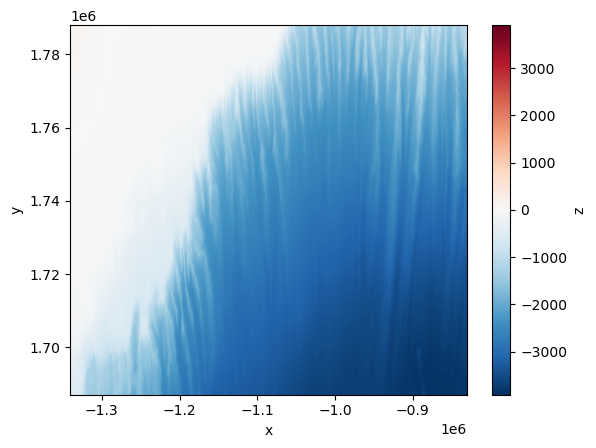

In [9]:
# Plot this trimmed data

#ibcao_data_trimmed = ibcao_data.sel(x=slice(x14, x24), y=slice(y14, y24))

ibcao_data_trimmed.z.plot()

In [10]:
# Convert data x,y to lon, lat
# Trimmed region
lon_x_360, lat_y = polar_xy_to_lonlat(ibcao_data_trimmed.x, ibcao_data_trimmed.y, 90, 6378137.0, 0.08181919, 1) #lon in (0 to 360) convention
lon_x = (lon_x_360 + 180) % 360 - 180 #lon in (-180 to 180) convention

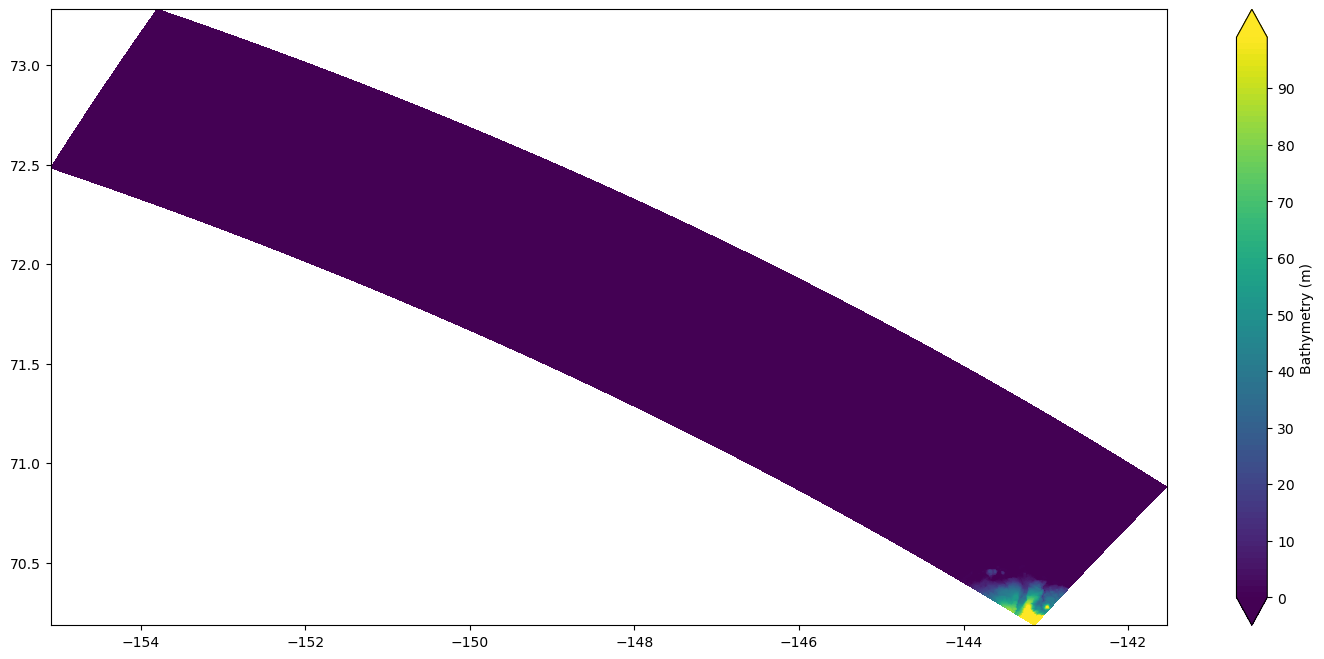

In [11]:
# Then plot
# Plot the bathymetry data in lat/lon

lev_bathy = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize=(18,8))

cs1 = ax.contourf(lon_x, lat_y, ibcao_data_trimmed.z.transpose(), levels=lev_bathy, extend='both')

fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [12]:
# Then try changing all to lat/lon and trimming

In [13]:
# Once we get the data to the region, convert to lat/lon


In [14]:
# # Convert data x,y to lon, lat
# # All data
# lon_x_360_all, lat_y_all = polar_xy_to_lonlat(ibcao_data.x, ibcao_data.y, 90, 6378137.0, 0.08181919, 1) #lon in (0 to 360) convention
# lon_x_all = (lon_x_360_all + 180) % 360 - 180 #lon in (-180 to 180) convention

In [15]:
# ibcao_data.z

In [16]:
# lat_y_all

In [17]:
# # Add in lat/lon as coordinates
# ibcao_data = ibcao_data.assign_coords(
#     lat=(('x','y'), lat_y_all.values),
#     lon=(('x','y'), lon_x_all.values)
# )

# # Set these as the coordinates
# ibcao_data =ibcao_data.set_coords(['lat', 'lon'])

In [18]:
# # Now try subsetting this
# lat_min, lat_max = 71.25, 71.8
# lon_min, lon_max = -153, -150

# mask = (
#     (ibcao_data.lat >= lat_min) & (ibcao_data.lat <= lat_max) &
#     (ibcao_data.lon >= lon_min) & (ibcao_data.lon <= lon_max)
# )

# ibcao_data_reg1 = ibcao_data.where(mask, drop=True)

In [19]:
# Mask out land 

#ibcao_data['z_noland'] = np.ma.masked_where(ibcao_data.z[:,:] > 0, ibcao_data.z, copy=True)

# ibcao_data['z_noland'] = ibcao_data.z.where(ibcao_data.z <= 0)


In [20]:
#ibcao_data.z.dims

In [21]:
# # Plot the data

# # Set the bathymetry levels
# lev_bathy = np.arange(-100, 0, 10)

# # Make the figure
# fig, ax = plt.subplots(figsize=(18,8), subplot_kw={"projection": ccrs.PlateCarree()})

# # Plot the bathymetry data
# cs1 = ax.contourf(ibcao_data.lon, ibcao_data.lat, ibcao_data.z_noland.transpose(), levels=lev_bathy, extend='min', transform=ccrs.PlateCarree())

# # Set the map extent
# ax.set_extent([-157, -137, 68, 73], ccrs.PlateCarree())

# # Add a colorbar 
# fig.colorbar(cs1, extend='min').set_label('Bathymetry (m)')

In [22]:
# So now that we have the data with lat/lon, 
# trim to this region and plot it, then 
# plot the alongshore mean to see how this looks

In [23]:
# Try to trim the data to the box
# ibcao_data_trimmed_latlon = ibcao_data.sel(lon=slice(-153,150),lat=slice(71,71.8))

In [24]:
# # Plot this
# # Plot the data

# # Set the bathymetry levels
# lev_bathy = np.arange(-1000, 0, 10)

# # Make the figure
# fig, ax = plt.subplots(figsize=(18,8), subplot_kw={"projection": ccrs.PlateCarree()})

# # Plot the bathymetry data
# cs1 = ax.contourf(ibcao_data_trimmed_latlon.lon, ibcao_data_trimmed_latlon.lat, ibcao_data_trimmed_latlon.z.transpose(), levels=lev_bathy, extend='both', transform=ccrs.PlateCarree())

# # Set the map extent
# ax.set_extent([-157, -137, 68, 73], ccrs.PlateCarree())

# # Add a colorbar 
# fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [25]:
# Then use that to trim to our box and plot it

In [26]:
# Then take the alongshore mean of this box spanning from coast to ~71.8 N 

In [27]:
# Then plot this to see how it looks


#### GEBCO  
Look at GEBCO data

In [28]:
# Load in the GEBCO data
gebco_data = xr.open_dataset('/pscratch/sd/d/dylan617/beaufort_roms/generate_inputs/gebco_2025_n75.0_s68.0_w-154.0_e-138.0.nc')
# Filter out land by looking only at negative values
bathy = gebco_data.elevation.where(gebco_data.elevation<0).where(gebco_data.lon>-153).where(gebco_data.lat<72)
print(bathy.lat.min().values)
print(bathy.lat.max().values)
print(bathy.lon.min().values)
print(bathy.lon.max().values)

68.00208333333333
74.99791666666667
-153.99791666666667
-138.00208333333333


In [29]:
gebco_data

<xarray.Dataset> Size: 13MB
Dimensions:    (lat: 1680, lon: 3840)
Coordinates:
  * lat        (lat) float64 13kB 68.0 68.01 68.01 68.01 ... 74.99 74.99 75.0
  * lon        (lon) float64 31kB -154.0 -154.0 -154.0 ... -138.0 -138.0 -138.0
Data variables:
    elevation  (lat, lon) int16 13MB 1138 1156 1182 1169 ... -3504 -3503 -3502
Attributes: (12/36)
    title:                           The GEBCO_2025 Grid - a continuous terra...
    summary:                         The GEBCO_2025 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    references:                      DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    node_offset:                     1.0

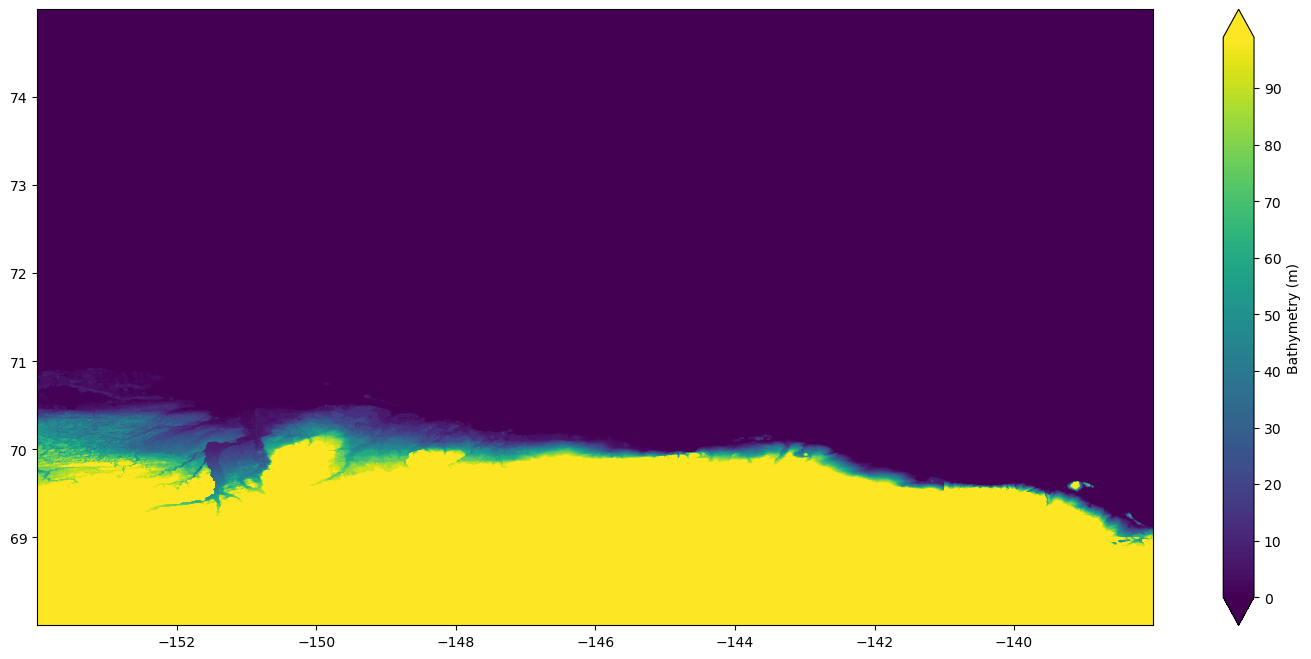

In [30]:
# Plot the GEBCO data in this region

lev_bathy = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize=(18,8))

cs1 = ax.contourf(gebco_data.lon, gebco_data.lat, gebco_data.elevation[:,:], levels=lev_bathy, extend='both')

fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [31]:
# Mask out land and only show ocean
gebco_data['bathymetry'] = gebco_data.elevation.where(gebco_data.elevation <= 0)


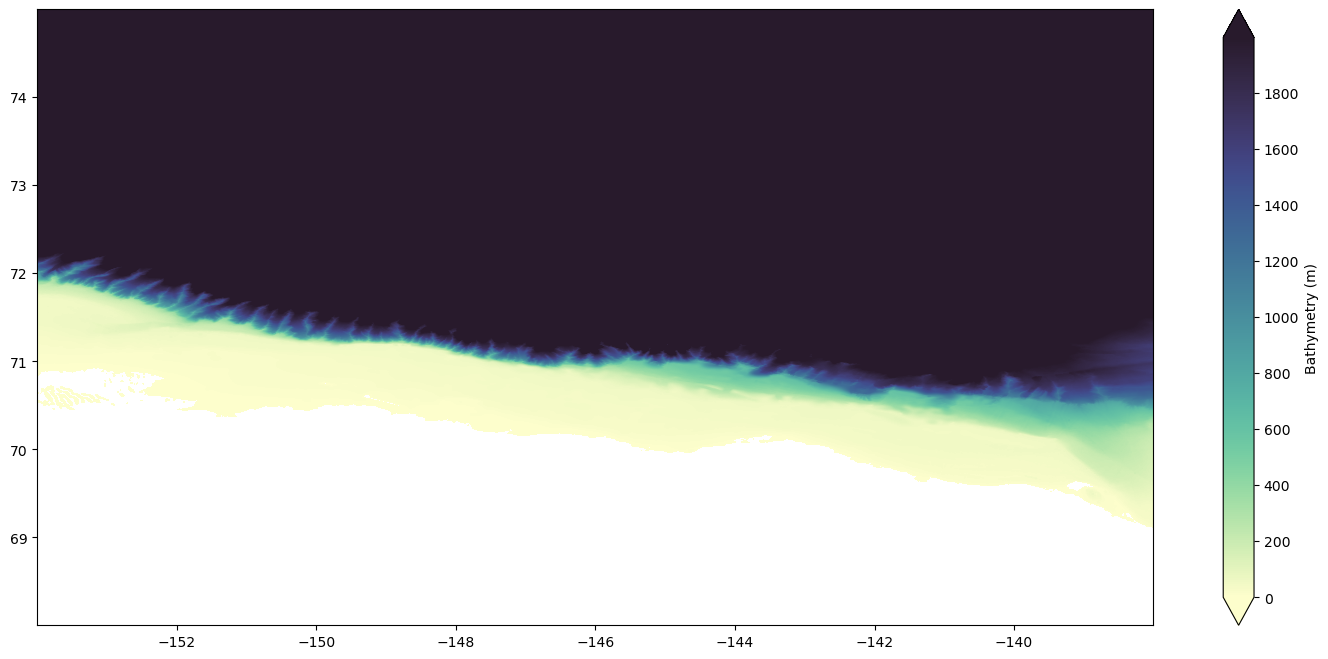

In [32]:
lev_bathy = np.arange(0, 2000, 1)

fig, ax = plt.subplots(figsize=(18,8))

cs1 = ax.contourf(gebco_data.lon, gebco_data.lat, gebco_data.bathymetry[:,:]*(-1), levels=lev_bathy, extend='both',
                  cmap=cmocean.cm.deep)

fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [33]:
# Okay now plot just the region of the box
# First trim the data
gebco_data_box = gebco_data.sel(lon=slice(-153,-150))

# Below is to trim to just where it is ocean but this leads to winkiness
# when you take the alongshore mean so things will be trimmed to just the 
# ocean after the mean is taken 
#gebco_data_box2 = gebco_data_box.where(gebco_data_box['elevation'] < 0, drop=True)

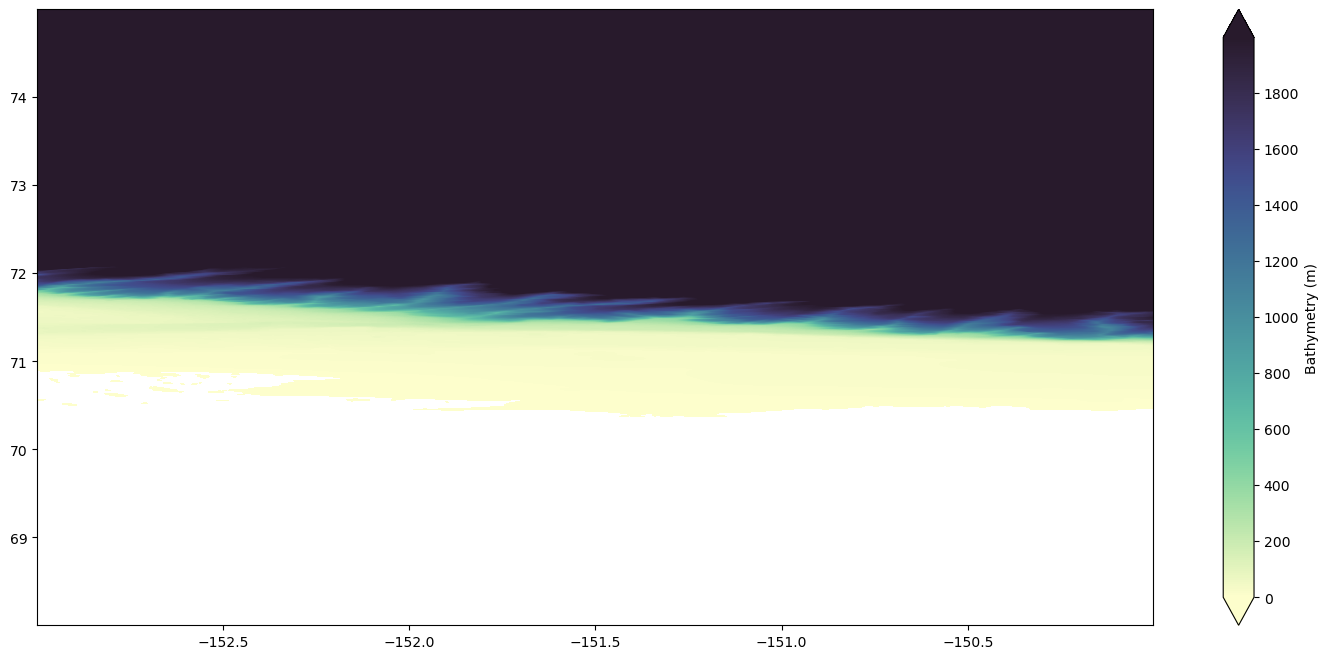

In [34]:
# Plot this
lev_bathy = np.arange(0, 2000, 1)

fig, ax = plt.subplots(figsize=(18,8))

cs1 = ax.contourf(gebco_data_box.lon, gebco_data_box.lat, gebco_data_box.bathymetry[:,:]*(-1), levels=lev_bathy, extend='both',
                  cmap=cmocean.cm.deep)

fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [35]:
# # Plot this
# lev_bathy = np.arange(0, 2000, 1)

# fig, ax = plt.subplots(figsize=(18,8))

# cs1 = ax.contourf(gebco_data_box2.lon, gebco_data_box2.lat, gebco_data_box2.bathymetry[:,:]*(-1), levels=lev_bathy, extend='both',
#                   cmap=cmocean.cm.deep)

# fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [36]:
# Take the alongshore mean of the bathymetry 
# (take mean over latitude but also this is slightly
# angled so might do some weird stuff with making it less
# steep than it really is butttttttt oh well it is 
# idealized model)
gebco_data_box['alongshore_mean_bathy'] = gebco_data_box.bathymetry.mean(dim='lon')
#gebco_data_box2['alongshore_mean_bathy'] = gebco_data_box2.bathymetry.mean(dim='lon')

Text(0, 0.5, 'Depth (m)')

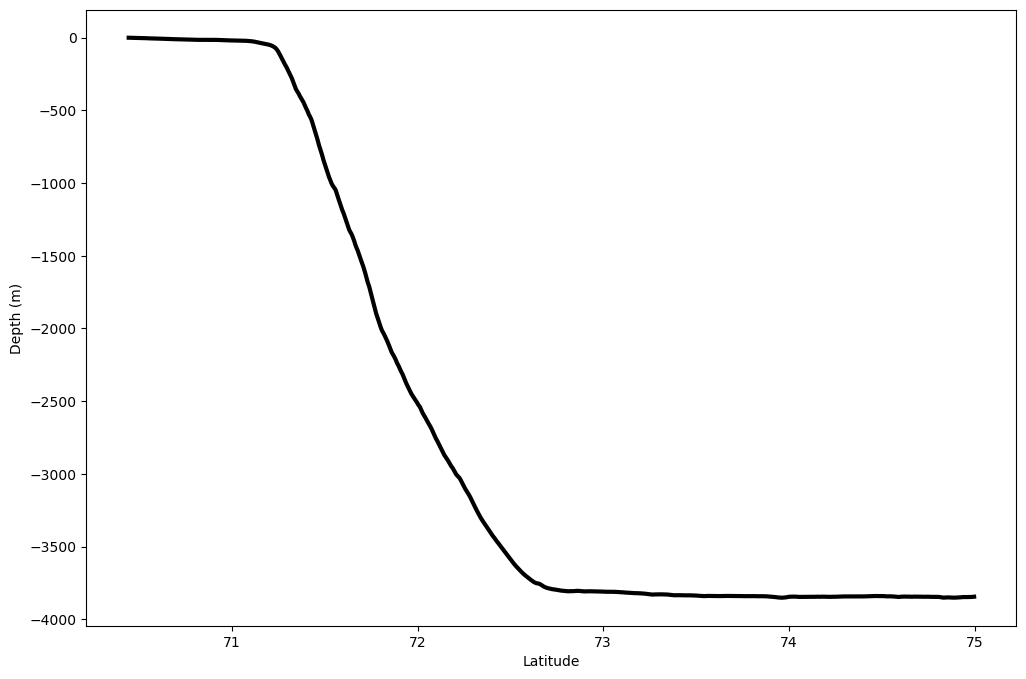

In [37]:
# Plot this mean 

# Make the figure
fig, ax = plt.subplots(figsize=(12,8))

# Plot the bathy
ax.plot(gebco_data_box.lat[586:], gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)

ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')


In [38]:
# # Plot this mean 

# # Make the figure
# fig, ax = plt.subplots(figsize=(12,8))

# # Plot the bathy
# ax.plot(gebco_data_box2.lat[586:], gebco_data_box2.alongshore_mean_bathy[586:], color='black', linewidth=3)

# ax.set_xlabel('Latitude')
# ax.set_ylabel('Depth (m)')

In [39]:
# Now plot this in m across-shore to see how steep this
# looks
# Convert these latitudes to m (or km)
# Use very simple 1 degree lat = 111 km 
gebco_data_box['lat_dist_km'] = gebco_data_box.lat*111



Text(0, 0.5, 'Depth (m)')

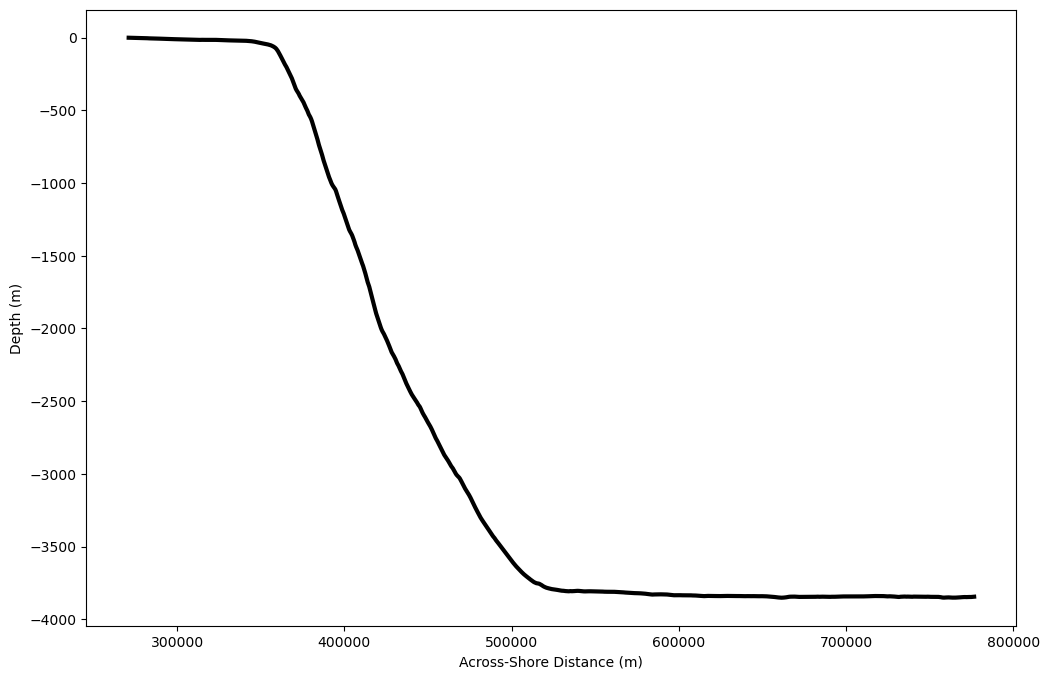

In [40]:
# Plot this again 
# Make the figure
fig, ax = plt.subplots(figsize=(12,8))

# Plot the bathy
ax.plot((gebco_data_box.lat_dist_km-gebco_data_box.lat_dist_km[0])[586:]*1000, gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)
#ax.set_aspect(1.0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

In [41]:
# Make a variable for distance across-shore
gebco_data_box['across_shelf_dist_km'] = gebco_data_box.lat_dist_km - gebco_data_box.lat_dist_km[0]
print(len(gebco_data_box.across_shelf_dist_km))

1680


Text(0, 0.5, 'Depth (m)')

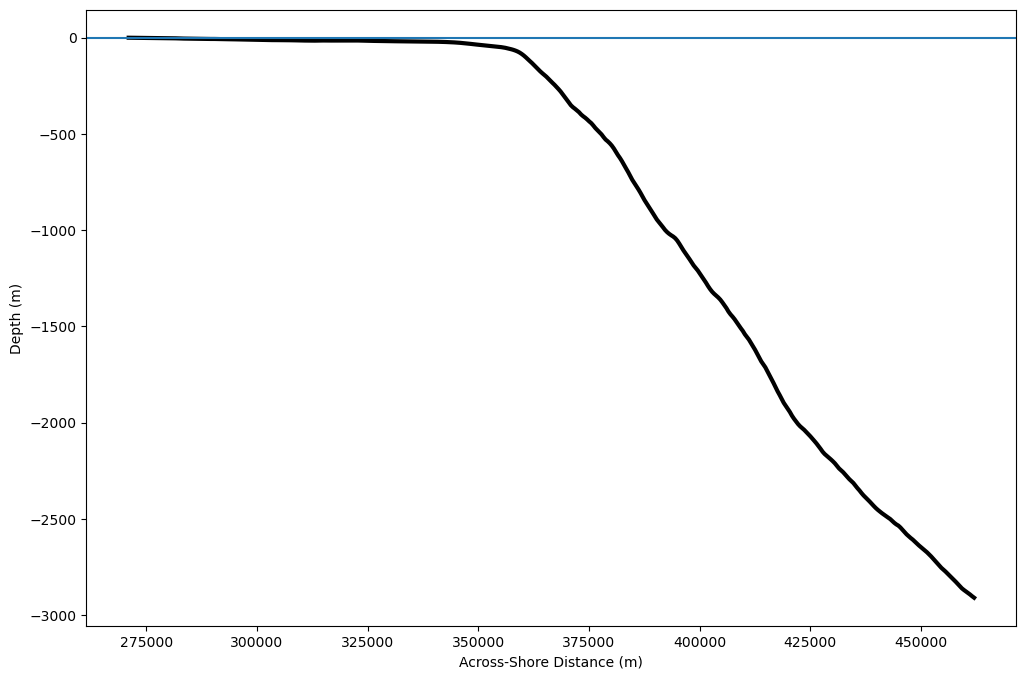

In [42]:
# Try to plot this again but with similar aspect ratio 
# (and trim to not be plotted too far offshore)
# Make the figure
fig, ax = plt.subplots(figsize=(12,8))

# Plot the bathy
ax.plot((gebco_data_box.across_shelf_dist_km[586:1000])*1000, gebco_data_box.alongshore_mean_bathy[586:1000], color='black', linewidth=3)
#ax.set_aspect(1.0)
ax.axhline(y=0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

In [43]:
# Hold please, gotta check that this is starting where the ocean
# actually starts, not on land
# Now it does so go back and trim all of those plots to that data 
print(gebco_data_box.alongshore_mean_bathy[586:600].values)

[-0.10240964 -0.22261484 -0.28431374 -0.46687698 -0.64890283 -0.722561
 -0.7891566  -0.88145894 -0.9909639  -1.005618   -1.0327868  -1.1042781
 -1.0420792  -1.1476997 ]


In [44]:
# Now we want to make a tanh fit of this...soooooo get 
# everything in m and then plot the full profile (after 
# ocean starts), and then fit a tanh to this and we can 
# trim it to the across-shelf distance that we want 
# then add noise 

# Make a variable that is across-shore distance in
gebco_data_box['across_shelf_dist_m'] = gebco_data_box.across_shelf_dist_km*1000

# Make variables that are across-shelf distanc e but from first ocean cell
across_shelf_dist_km_ocean = gebco_data_box.lat_dist_km[586:] - gebco_data_box.lat_dist_km[586]
across_shelf_dist_m_ocean = across_shelf_dist_km_ocean*1000


In [45]:
print(len(across_shelf_dist_km_ocean))
print(len(gebco_data_box.across_shelf_dist_km))

1094
1680


Text(0, 0.5, 'Depth (m)')

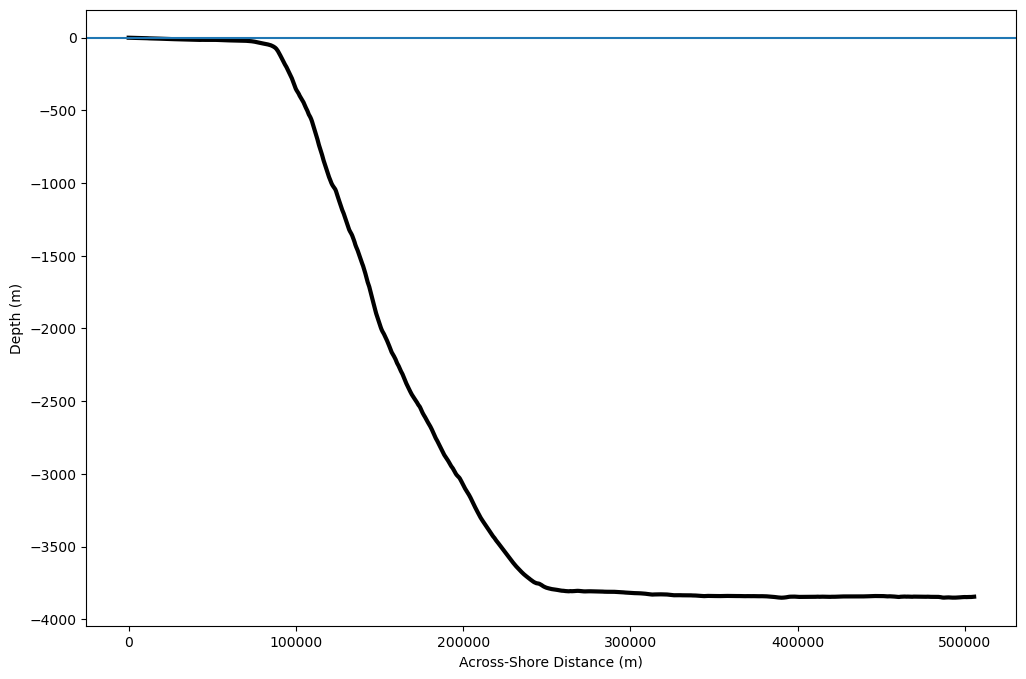

In [46]:
# Plot this full profile to be fitted
fig, ax = plt.subplots(figsize=(12,8))

# Plot the bathy
ax.plot((across_shelf_dist_m_ocean), gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)
#ax.set_aspect(1.0)
ax.axhline(y=0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

In [47]:
# Fit a tanh to this

# Make a function to get a tanh profile
def tanh_func(x, a, b, c, d):
        return a * np.tanh(b * (x + c)) + d

In [48]:
# Make an initial guess on the fit
initial_tanh_guess = (-2000, 1, 0, -2000) # (a, b, c, d)

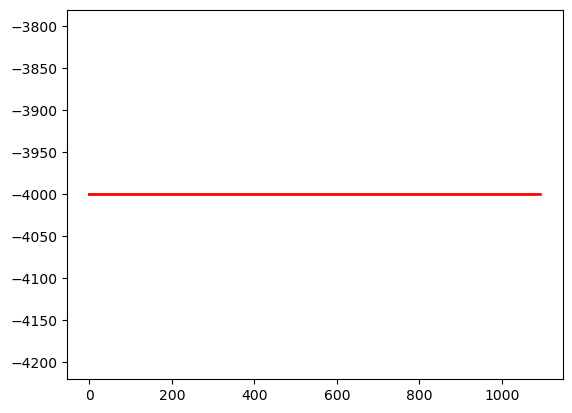

In [49]:
# Plot the initial guess
plt.plot(tanh_func(gebco_data_box.across_shelf_dist_m[586:], *initial_tanh_guess), color='r', linewidth=2)

In [50]:
# Try a fit
params, covariance = curve_fit(tanh_func, gebco_data_box.across_shelf_dist_m[586:], gebco_data_box.alongshore_mean_bathy[586:], p0=initial_tanh_guess)

/tmp/ipykernel_1445321/279519468.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(tanh_func, gebco_data_box.across_shelf_dist_m[586:], gebco_data_box.alongshore_mean_bathy[586:], p0=initial_tanh_guess)


In [51]:
# Get the parameters
a_fit, b_fit, c_fit, d_fit = params

# Make a curve out of this
bathy_tanh_fit = tanh_func(gebco_data_box.across_shelf_dist_m[586:], *params)

Text(0, 0.5, 'Depth (m)')

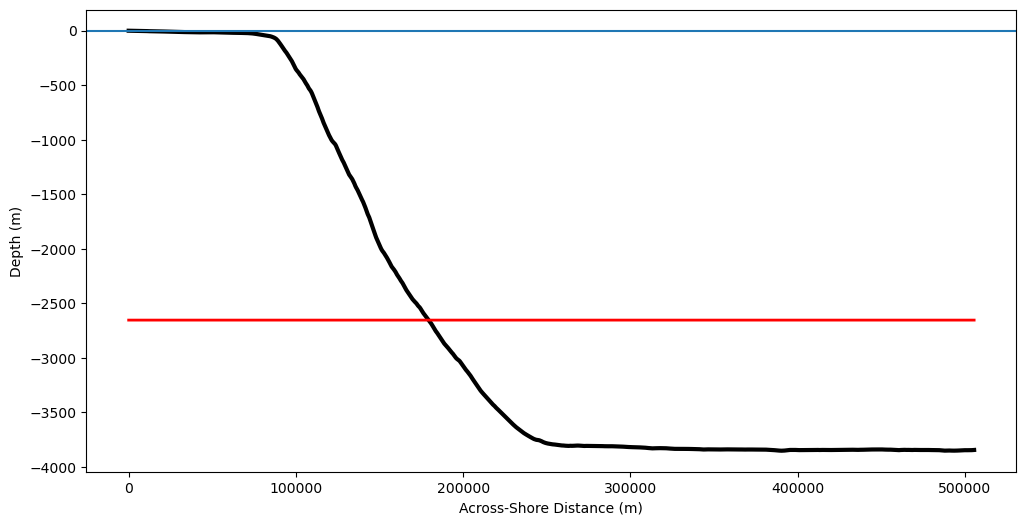

In [52]:
# Plot it on top of the OG
# Plot this full profile with fit
fig, ax = plt.subplots(figsize=(12,6))

# Plot the bathy
ax.plot((across_shelf_dist_m_ocean), gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)
ax.plot((across_shelf_dist_m_ocean), bathy_tanh_fit, color='r', linewidth=2)
ax.plot()
#ax.set_aspect(1.0)
ax.axhline(y=0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

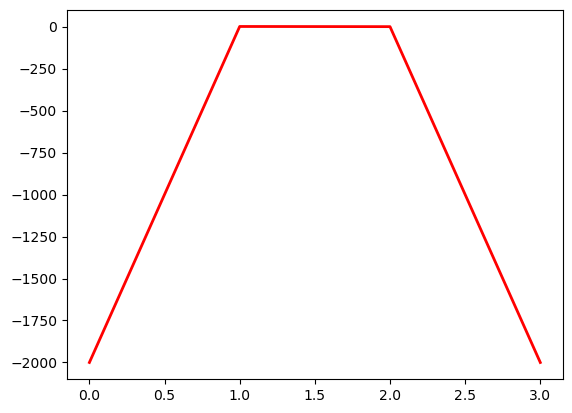

In [53]:
plt.plot(initial_tanh_guess, color='r', linewidth=2)

In [54]:
# Take 2 at a fit - this works much better than what I was doing so play with this!
def tanh_bathymetry(x, H_min, H_offshore, x_mid, L):
        return H_min + 0.5 * (H_offshore - H_min) * (1 + np.tanh((x - x_mid) / L))
        #return  0.5 * (H_offshore - H_min) * (1 + np.tanh((x - x_mid) / L))

# Initial guesses
H_min_guess = gebco_data_box.alongshore_mean_bathy[586]
H_offshore_guess = gebco_data_box.alongshore_mean_bathy[-1]
x_mid_guess = across_shelf_dist_m_ocean[np.argmax(np.gradient(gebco_data_box.alongshore_mean_bathy[586:], across_shelf_dist_m_ocean))]
L_guess = 100000  # typical slope width (km)
p0 = [H_min_guess, H_offshore_guess, x_mid_guess - 10, L_guess]

popt, _ = curve_fit(tanh_bathymetry, across_shelf_dist_m_ocean, gebco_data_box.alongshore_mean_bathy[586:], p0=p0)

In [55]:
b_fit = np.abs(tanh_bathymetry(gebco_data_box.across_shelf_dist_m, *popt))

H_min, H_offshore, x_mid, L = popt
print(f"Fitted tanh parameters:\n H_min={H_min:.2f}, H_offshore={H_offshore:.2f}, x_mid={x_mid:.2f}, L={L:.2f}")

Fitted tanh parameters:
 H_min=121.90, H_offshore=-3845.38, x_mid=151553.00, L=58525.37


Text(0, 0.5, 'Depth (m)')

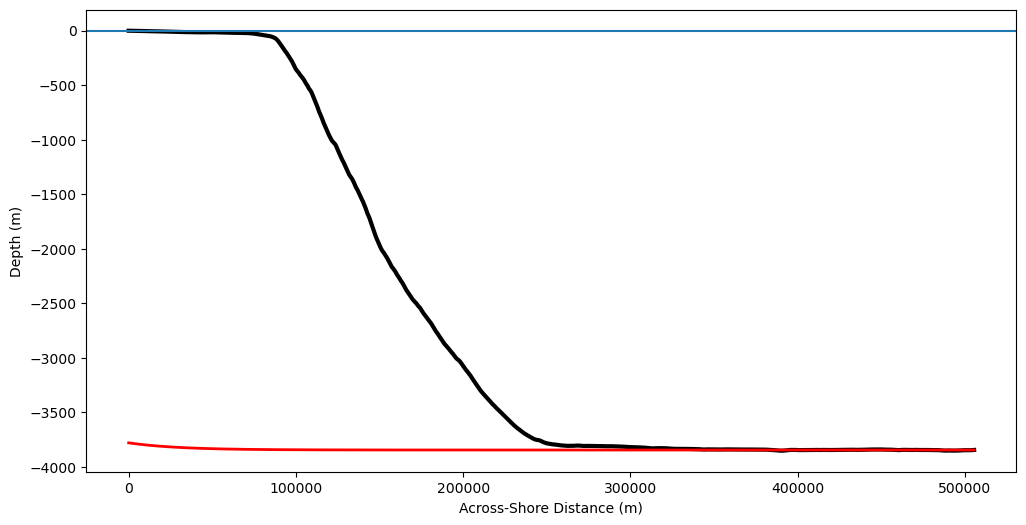

In [56]:
# Plot this full profile with fit
fig, ax = plt.subplots(figsize=(12,6))

# Plot the bathy
ax.plot((across_shelf_dist_m_ocean), gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)
ax.plot((across_shelf_dist_m_ocean), (-1)*b_fit[586:], color='r', linewidth=2)
ax.plot()
#ax.set_aspect(1.0)
ax.axhline(y=0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

In [57]:
# Try again but asymmetric 
# def asymmetric_tanh_bathy(x, H_min, H_offshore, x_mid, L_up, L_down):
#     """
#     L_up   = scaling left of x_mid (shelf / top)
#     L_down = scaling right of x_mid (slope / deep)
#     """
#     # piecewise asymmetric tanh
#     L = np.where(x < x_mid, L_up, L_down)
#     return H_min + 0.5 * (H_offshore - H_min) * (1 + np.tanh((x - x_mid) / L))

# def asymmetric_tanh_bathy(x, H_min, H_offshore, x_mid, L_top, L_bottom):
#     """
#     L_top: small value → sharper break near shelf edge
#     L_bottom: large value → smoother deep slope
#     """
#     L = np.where(x < x_mid, L_top, L_bottom)
#     return H_min + 0.5*(H_offshore - H_min)*(1 + np.tanh((x - x_mid)/L))

def asymmetric_tanh_bathy(x, H_min, H_offshore, x_mid, L_top, L_bottom):
    """
    L_top:    small  -> sharp shelf edge
    L_bottom: large  -> smooth deep slope
    """

    # Reverse tanh direction: use (x_mid - x) instead of (x - x_mid)
    L = np.where(x < x_mid, L_top, L_bottom)

    return H_min + 0.5*(H_offshore - H_min)*(1 + np.tanh((x_mid - x)/L))




In [58]:
x = across_shelf_dist_m_ocean
y = gebco_data_box.alongshore_mean_bathy[586:]

# Initial guesses:
H_min_guess2 = np.max(y)
H_offshore_guess2 = y[-1]
x_mid_guess2 = x[np.argmax(np.gradient(y, x))]
L_up_guess2 = 5000     # short, sharp top, 120000
L_down_guess2 = 120000  # wide deep slope, 100000

p02 = [H_min_guess2, H_offshore_guess2, x_mid_guess2, L_up_guess2, L_down_guess2]

popt2, _ = curve_fit(asymmetric_tanh_bathy, x, y, p0=p02, maxfev=20000)
H_min2, H_offshore2, x_mid2, L_up2, L_down2 = popt2

b_fit2 = asymmetric_tanh_bathy(across_shelf_dist_m_ocean, *popt2)

In [59]:
print('H_min_guess2: ', H_min_guess2.values)
print('H_offshore_guess2: ', H_offshore_guess2.values)

H_min_guess2:  -0.10240964
H_offshore_guess2:  -3844.925


Text(0, 0.5, 'Depth (m)')

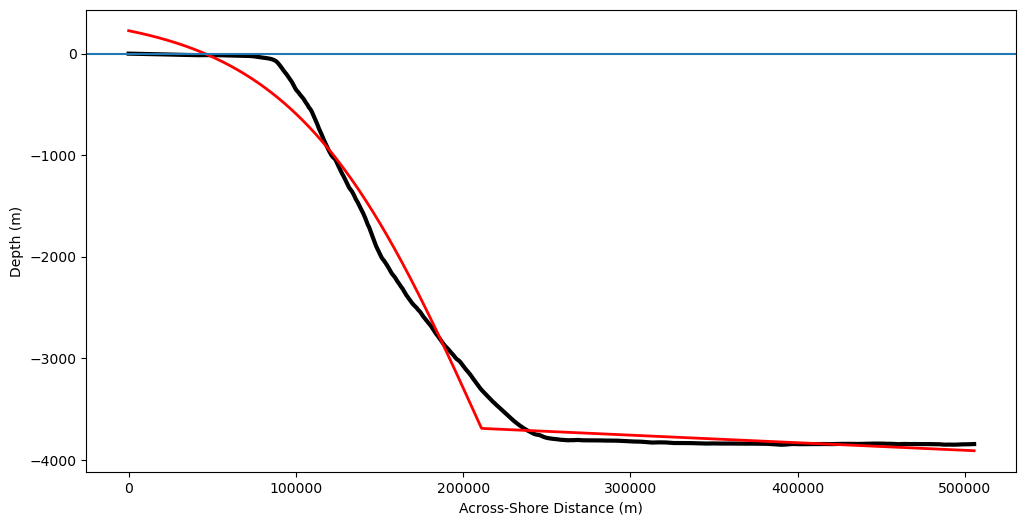

In [60]:
# Plot this full profile with fit
fig, ax = plt.subplots(figsize=(12,6))

# Plot the bathy
ax.plot((across_shelf_dist_m_ocean), gebco_data_box.alongshore_mean_bathy[586:], color='black', linewidth=3)
ax.plot((across_shelf_dist_m_ocean), b_fit2, color='r', linewidth=2)
ax.plot()
#ax.set_aspect(1.0)
ax.axhline(y=0)

ax.set_xlabel('Across-Shore Distance (m)')
ax.set_ylabel('Depth (m)')

In [61]:
# Plot it

In [62]:
# Add noise

In [63]:
# Then we have the profile

In [64]:
# Then take the alongshore mean and plot that, 
# extending further out into the abyss since we need to 
# extend the domain 


#### Model Grid  
Look at how the model grid bathymetry profile looks now

In [65]:
# Look at what the grid does right now
grid_1km = xr.open_dataset('/global/homes/b/bundzis/Projects/Beaufort_ROMS_idealized_jet/Include/grd_1km.nc')


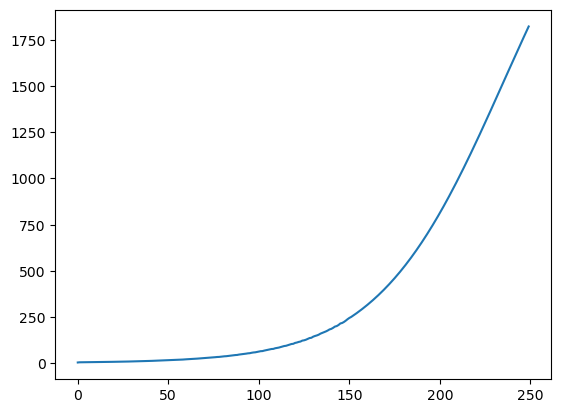

In [66]:
plt.plot(grid_1km.h[:,10])

In [67]:
# Load in another grid
grid_2 = grid_1km = xr.open_dataset('/global/homes/b/bundzis/Projects/Beaufort_ROMS_idealized_jet/Include/grd_1km_003.nc')

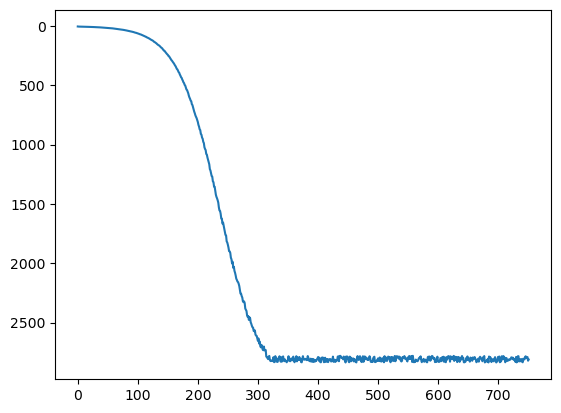

In [74]:
fig, ax = plt.subplots()

ax.plot(grid_2.h[:,10])
ax.invert_yaxis()